# Nonparametric quantification of uncertainty of text classification models using conformal prediction

## Dataset

In [1]:
from datasets import load_dataset
import numpy as np
dataset = load_dataset('amazon_polarity')
smaller_dataset = dataset.filter(lambda e, i: i<10000, with_indices=True)

Reusing dataset amazon_polarity (/Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-85a5ef740c83d822.arrow
Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-2bdc61d32851d4ff.arrow


## Models

### BERT

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True)

In [3]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
smaller_tokenized_dataset = smaller_dataset.map(preprocess_function, batched=True)

Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-e900afe240cf7a60.arrow
Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-face6c0b185608c0.arrow
Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-63c4d51e197c9ec5.arrow


  0%|          | 0/10 [00:00<?, ?ba/s]

In [4]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [5]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

In [6]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=smaller_tokenized_dataset["train"],
    eval_dataset=smaller_tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, title.
***** Running training *****
  Num examples = 10000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3125


Step,Training Loss
500,0.407500
1000,0.298400
1500,0.230200
2000,0.169100
2500,0.133200
3000,0.093900


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1500/special_toke

TrainOutput(global_step=3125, training_loss=0.2168090200805664, metrics={'train_runtime': 2039.4234, 'train_samples_per_second': 24.517, 'train_steps_per_second': 1.532, 'total_flos': 212171376584832.0, 'train_loss': 0.2168090200805664, 'epoch': 5.0})

In [7]:
predicted = trainer.predict(smaller_tokenized_dataset["test"])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, title.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 16


In [8]:
import torch
predicted_proba = torch.nn.functional.softmax(torch.tensor(predicted.predictions), dim=1)

In [9]:
data_bert = predicted_proba[:,1].numpy(), np.array(smaller_tokenized_dataset["test"]["label"])

## Evaluation

##### Supporting code

In [10]:
import VennABERS
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
def plot_venn_abers(data):
    venn_abers = VennABERS.ScoresToMultiProbs(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.3)
    plt.axis((0, 1, 0, 1))

def plot_isotonic_regression(data):
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba)
    plt.axis((0, 1, 0, 1))

def plot_all(data):
    venn_abers = VennABERS.ScoresToMultiProbs(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.3)
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba)
    plt.axis((0, 1, 0, 1))
    plt.legend(["Venn-Abers", "Venn-Abers Interval", "Isotonic Regression"])

### BERT

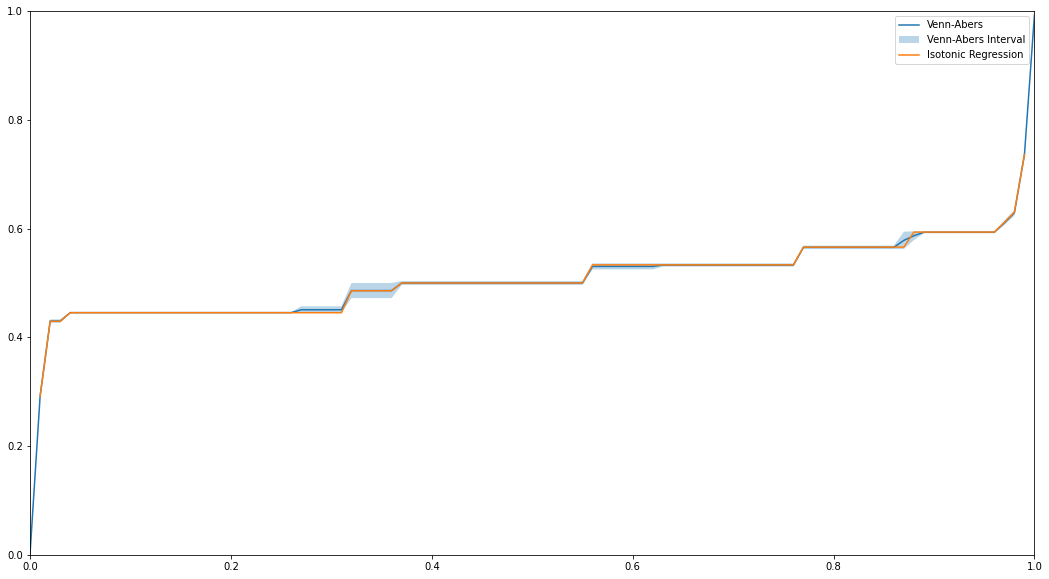

In [12]:
plot_all(data_bert)